### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as wb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Retrieve Returns Time-Series

In [2]:
macro = pd.read_csv('macro_momentum_return.csv', index_col=0, parse_dates=True)
macro.columns = ['Macro']

dia = pd.read_csv('dow_jones_timing_return.csv', index_col=0, parse_dates=True)
dia.columns = ['DIA']

spy = wb.DataReader('SPY', 'yahoo', macro.index[0], macro.index[-1])[['Adj Close']].pct_change()
spy.columns = ['SPY']

### Compute Overall Return

In [3]:
combined = pd.concat([macro, dia, spy], axis=1)
combined.fillna(method='pad', inplace=True)
combined = combined.loc['2005':]
combined.fillna(0, inplace=True)

### Backtest Strategy

In [4]:
# functionalize Sharpe ratio
def sharpe(daily_return):
    return daily_return.mean() / daily_return.std() * np.sqrt(250)

# functionalize maximum drawdown
def max_dd(daily_return):
    roll_max = (daily_return + 1).cumprod().expanding().max()
    daily_dd = (daily_return + 1).cumprod() / roll_max.values - 1.0
    max_dd = daily_dd.abs().max() * 100
    return max_dd

# functionalize annualized return
def annualized_return(daily_return):
    cum_return = (daily_return + 1).cumprod().dropna()
    ann_return = (cum_return.iloc[-1] / cum_return.iloc[0]) ** (1 / len(cum_return) * 252) - 1
    ann_return = ann_return * 100
    return ann_return

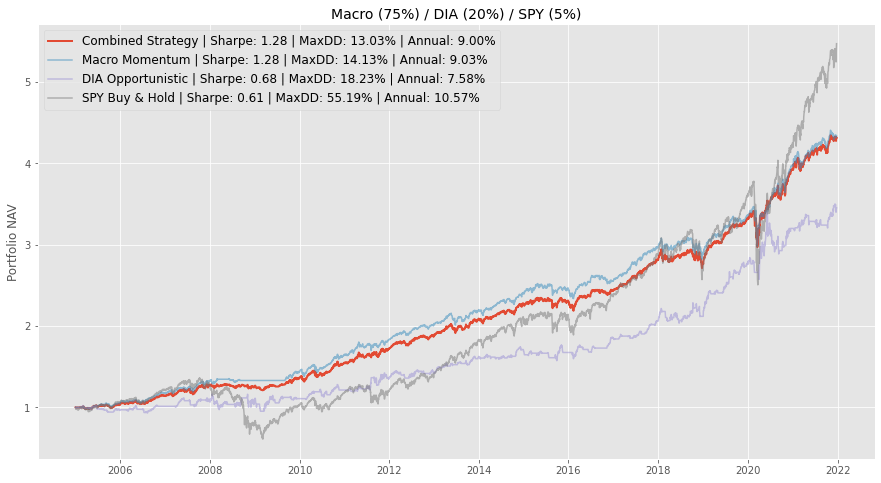

In [5]:
# calculate daily portfolio return
macro_alloc = 75
dia_alloc = 20
spy_alloc = 5
strat = (combined * [macro_alloc/100, dia_alloc/100, spy_alloc/100]).sum(axis=1)
macro = combined['Macro']
dia = combined['DIA']
spy = combined['SPY']

# plot PnL
plt.figure(figsize=(15,8))
plt.plot((strat + 1).cumprod(), label=f"Combined Strategy | Sharpe: {sharpe(strat):.2f} | MaxDD: {max_dd(strat):.2f}% | Annual: {annualized_return(strat):.2f}%", lw=2)
plt.plot((macro + 1).cumprod(), label=f"Macro Momentum | Sharpe: {sharpe(macro):.2f} | MaxDD: {max_dd(macro):.2f}% | Annual: {annualized_return(macro):.2f}%", alpha=0.5)
plt.plot((dia + 1).cumprod(), label=f"DIA Opportunistic | Sharpe: {sharpe(dia):.2f} | MaxDD: {max_dd(dia):.2f}% | Annual: {annualized_return(dia):.2f}%", alpha=0.5)
plt.plot((spy + 1).cumprod(), label=f"SPY Buy & Hold | Sharpe: {sharpe(spy):.2f} | MaxDD: {max_dd(spy):.2f}% | Annual: {annualized_return(spy):.2f}%", alpha=0.5)

plt.title(f"Macro ({macro_alloc}%) / DIA ({dia_alloc}%) / SPY ({spy_alloc}%)", fontsize=14)
# plt.xlabel(f"\nMacro / DIA Correlation: {round(macro.corr(dia),2)}")
plt.ylabel('Portfolio NAV', fontsize=12)
plt.legend(fontsize=12)
plt.show()

### Annual Returns Distribution

In [6]:
strat.dropna().resample('A').sum() * 100

Date
2005-12-31     2.979498
2006-12-31    10.808468
2007-12-31    10.853354
2008-12-31    -0.956732
2009-12-31     7.660455
2010-12-31    13.770420
2011-12-31    10.801836
2012-12-31     9.072561
2013-12-31    10.853063
2014-12-31     7.935905
2015-12-31     1.954806
2016-12-31     5.792454
2017-12-31    14.435700
2018-12-31    -0.886515
2019-12-31    17.811262
2020-12-31    17.905806
2021-12-31     9.441845
Freq: A-DEC, dtype: float64

## The End